In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm

# Load Data
gene, taxon profile sizes and the similarity scores for eah pair

In [34]:
def load_data():
	
    input = pd.read_csv('../../data/real_data_experiment/experiment/results/random_scores_sizes_filtered.tsv',\
                           sep='\t', header=0)
#     inFile = open("../../data/real_data_experiment/experiment/results/random_scores_sizes.tsv")
    
    scores = input['Median nIC']
    gene_profile_sizes = input['gene_size']
    taxon_profile_sizes = input['taxon_size']
    
#     scores = []
#     gene_profile_sizes = []
#     taxon_profile_sizes = []

#     for line in inFile:
#         if "Score" not in line:
#             data = line.strip().split("\t")
#             score = float(data[3])
#             scores.append(score)
#             gene_profile_sizes.append(int(data[1]))
#             taxon_profile_sizes.append(int(data[4]))
#     inFile.close()
    
    return scores, gene_profile_sizes, taxon_profile_sizes

In [35]:
scores, gene_profile_sizes, taxon_profile_sizes = load_data()
gene_taxon_scores = pd.DataFrame(
    {
        'gene': gene_profile_sizes,
        'taxon': taxon_profile_sizes,
        'scores': scores
    })
print(gene_taxon_scores.head())

   gene  taxon  scores
0    85     11   0.050
1   123     11   0.060
2    64     11   0.050
3    20     11   0.020
4   124     11   0.055


# Data Transformation

1. Log Transformations
We will obtain the log for taxon/gene profile sizes, similarity score. These values will be used later in multiple linear regressions. 

2. Box Cox - power transformation
This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like.

## 1. Log Transformation

Gene Logarithm, Taxon Logarithm, Scores

In [36]:
geneLog = gene_taxon_scores['gene'].apply(np.log)
taxonLog = gene_taxon_scores['taxon'].apply(np.log)

geneLog_taxonLog_scores = gene_taxon_scores.copy(deep=True)
geneLog_taxonLog_scores.rename(columns={'gene':'geneLog', 'taxon':'taxonLog'}, inplace=True)   
geneLog_taxonLog_scores['geneLog'] = geneLog
geneLog_taxonLog_scores['taxonLog'] = taxonLog
print(geneLog_taxonLog_scores.head())

    geneLog  taxonLog  scores
0  4.442651  2.397895   0.050
1  4.812184  2.397895   0.060
2  4.158883  2.397895   0.050
3  2.995732  2.397895   0.020
4  4.820282  2.397895   0.055


Gene Logarithm, Taxon Logarithm, Scores Logarithm

In [37]:
geneLog_taxonLog_scoresLog = geneLog_taxonLog_scores.copy(deep=True)
scoresLog = gene_taxon_scores['scores'].apply(np.log)
geneLog_taxonLog_scoresLog['scores'] = scoresLog
geneLog_taxonLog_scoresLog.rename(columns={'scores':'scoresLog'}, inplace=True)   
print(geneLog_taxonLog_scoresLog.head())

    geneLog  taxonLog  scoresLog
0  4.442651  2.397895  -2.995732
1  4.812184  2.397895  -2.813411
2  4.158883  2.397895  -2.995732
3  2.995732  2.397895  -3.912023
4  4.820282  2.397895  -2.900422


## 2. Box Cox Transformation

Gene Box Cox, Taxon Box Cox, Scores

In [38]:
geneBoxCox, lmbda1 = ss.boxcox(gene_taxon_scores['gene'])
taxonBoxCox, lmbda2 = ss.boxcox(gene_taxon_scores['taxon'])

geneBoxCox_taxonBoxCox_scores = gene_taxon_scores.copy(deep=True)
geneBoxCox_taxonBoxCox_scores.rename(columns={'gene':'geneBoxCox', 'taxon':'taxonBoxCox'}, inplace=True)   
geneBoxCox_taxonBoxCox_scores['geneBoxCox'] = geneBoxCox
geneBoxCox_taxonBoxCox_scores['taxonBoxCox'] = taxonBoxCox
print(geneBoxCox_taxonBoxCox_scores.head())

   geneBoxCox  taxonBoxCox  scores
0    4.853590     24.19161   0.050
1    5.296738     24.19161   0.060
2    4.517630     24.19161   0.050
3    3.178995     24.19161   0.020
4    5.306520     24.19161   0.055


Gene Box Cox, Taxon Box Cox, Scores Box Cox

In [39]:
geneBoxCox_taxonBoxCox_scoresBoxCox = geneBoxCox_taxonBoxCox_scores.copy(deep=True)
scoresBoxCox, lmbda3 = ss.boxcox(geneBoxCox_taxonBoxCox_scores['scores'])
geneBoxCox_taxonBoxCox_scoresBoxCox['scores'] = scoresBoxCox
geneBoxCox_taxonBoxCox_scoresBoxCox.rename(columns={'scores':'scoresBoxCox'}, inplace=True)   
print(geneBoxCox_taxonBoxCox_scoresBoxCox.head())

   geneBoxCox  taxonBoxCox  scoresBoxCox
0    4.853590     24.19161     -2.265524
1    5.296738     24.19161     -2.162366
2    4.517630     24.19161     -2.265524
3    3.178995     24.19161     -2.731624
4    5.306520     24.19161     -2.212057


# Multiple linear regression

Next we'll try multiple linear regression with 2 approaches thowards least squares: OLS and WLS.
Each model will be run for different data combinations. For each model we will plot the residuals and print the resulting model summary.

## OLS Multi Regression

In [40]:
def ols_multiple_regression(input_data, isTaxonLog, isGeneLog, isScoreLog, 
                            isTaxonBoxCox, isGeneBoxCox, isScoreBoxCox):
    
    if input_data is None:
        return
    
    if isTaxonBoxCox is True and isGeneBoxCox is True and isScoreBoxCox is True:
        results = smf.ols(formula='scoresBoxCox ~ taxonBoxCox + geneBoxCox', data=input_data).fit()
        return results
    
    if isTaxonBoxCox is True and isGeneBoxCox is True and isScoreBoxCox is False:
        results = smf.ols(formula='scores ~ taxonBoxCox + geneBoxCox', data=input_data).fit()
        return results
    
    if isTaxonLog is False and isGeneLog is False and isScoreLog is False:
        results = smf.ols(formula='scores ~ taxon + gene', data=input_data).fit()
        return results
    
    if isTaxonLog is True and isGeneLog is True and isScoreLog is False:
        results = smf.ols(formula='scores ~ taxonLog + geneLog', data=input_data).fit()
        return results
    
    if isTaxonLog is True and isGeneLog is True and isScoreLog is True:
        results = smf.ols(formula='scoresLog ~ taxonLog + geneLog', data=input_data).fit()
        return results    

In [41]:
def compute_residuals(results, input_data):

    residuals_taxon_gene = []
    actual_taxon_gene = input_data.iloc[:,2]
    predicted_taxon_gene = results.fittedvalues
    
    for x in range(0, len(actual_taxon_gene)):
            actual_score = actual_taxon_gene[x]
            predicted_score = predicted_taxon_gene[x]
            residual = actual_score - predicted_score
            residuals_taxon_gene.append(residual)
            
    return residuals_taxon_gene

## OLS on gene profile size, taxon profile size, scores.

In [42]:
ols_results_gene_taxon_Scores = ols_multiple_regression(gene_taxon_scores, False, False, False, 
                                                       False, False, False)
print(ols_results_gene_taxon_Scores.params)
print('R squared '+str(ols_results_gene_taxon_Scores.rsquared))
print('Adjusted R squared '+str(ols_results_gene_taxon_Scores.rsquared_adj))
print(ols_results_gene_taxon_Scores.summary())

Intercept    0.031567
taxon       -0.000296
gene         0.000120
dtype: float64
R squared 0.42180123439744166
Adjusted R squared 0.4217873648946867
                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                 3.041e+04
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:42   Log-Likelihood:             2.1333e+05
No. Observations:               83380   AIC:                        -4.266e+05
Df Residuals:                   83377   BIC:                        -4.266e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

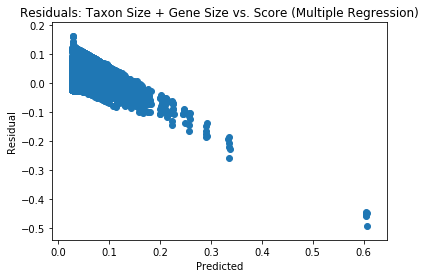

In [43]:
residuals = compute_residuals(ols_results_gene_taxon_Scores, gene_taxon_scores)
predicted = ols_results_gene_taxon_Scores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size + Gene Size vs. Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

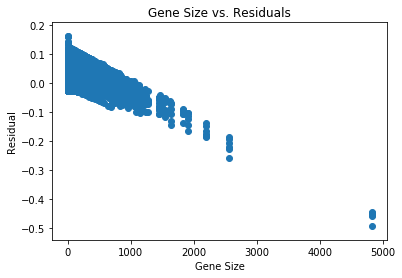

In [44]:
plt.scatter(np.array(gene_taxon_scores['gene']), np.array(residuals))
plt.title('Gene Size vs. Residuals')
plt.xlabel('Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

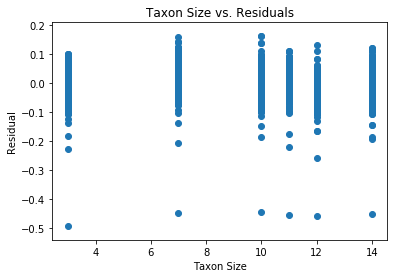

In [45]:
plt.scatter(np.array(gene_taxon_scores['taxon']), np.array(residuals))
plt.title('Taxon Size vs. Residuals')
plt.xlabel('Taxon Size')
plt.ylabel('Residual')

## OLS on log gene profile size, log taxon profile size, scores.

In [46]:
ols_results_geneLog_taxonLog_Scores = ols_multiple_regression(geneLog_taxonLog_scores, True, True, False,
                                                            False, False, False)
print(ols_results_geneLog_taxonLog_Scores.params)
print('R squared '+str(ols_results_geneLog_taxonLog_Scores.rsquared))
print('Adjusted R squared '+str(ols_results_geneLog_taxonLog_Scores.rsquared_adj))
print(ols_results_geneLog_taxonLog_Scores.summary())

Intercept    0.004534
taxonLog    -0.001067
geneLog      0.010885
dtype: float64
R squared 0.4801855941636257
Adjusted R squared 0.480173125151648
                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                 3.851e+04
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:45   Log-Likelihood:             2.1776e+05
No. Observations:               83380   AIC:                        -4.355e+05
Df Residuals:                   83377   BIC:                        -4.355e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

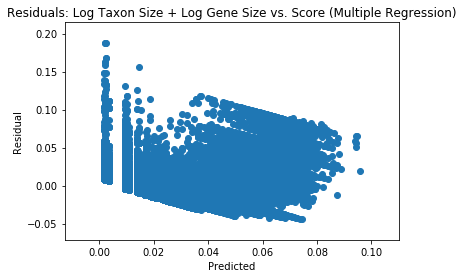

In [47]:
residuals = compute_residuals(ols_results_geneLog_taxonLog_Scores, geneLog_taxonLog_scores)
predicted = ols_results_geneLog_taxonLog_Scores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

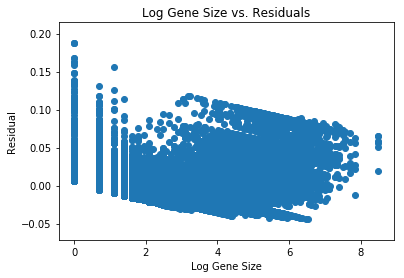

In [48]:
plt.scatter(np.array(geneLog_taxonLog_scores['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

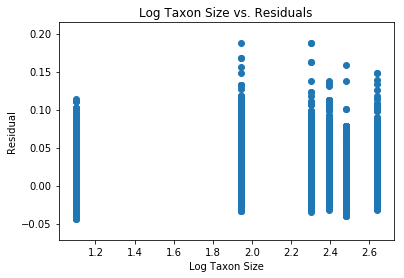

In [49]:
plt.scatter(np.array(geneLog_taxonLog_scores['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## OLS on log gene profile size, log taxon profile size, log scores.

In [50]:
ols_results_geneLog_taxonLog_ScoresLog = ols_multiple_regression(geneLog_taxonLog_scoresLog, True, True, True,
                                                               False, False, False)
print(ols_results_geneLog_taxonLog_ScoresLog.params)
print('R squared '+str(ols_results_geneLog_taxonLog_ScoresLog.rsquared))
print('Adjusted R squared '+str(ols_results_geneLog_taxonLog_ScoresLog.rsquared_adj))
print(ols_results_geneLog_taxonLog_ScoresLog.summary())

Intercept   -4.537145
taxonLog     0.014296
geneLog      0.311703
dtype: float64
R squared 0.5134943474179336
Adjusted R squared 0.5134826773973624
                            OLS Regression Results                            
Dep. Variable:              scoresLog   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                 4.400e+04
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:48   Log-Likelihood:                -56355.
No. Observations:               83380   AIC:                         1.127e+05
Df Residuals:                   83377   BIC:                         1.127e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

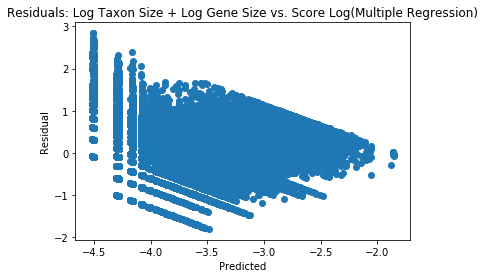

In [51]:
residuals = compute_residuals(ols_results_geneLog_taxonLog_ScoresLog, geneLog_taxonLog_scoresLog)
predicted = ols_results_geneLog_taxonLog_ScoresLog.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Score Log(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

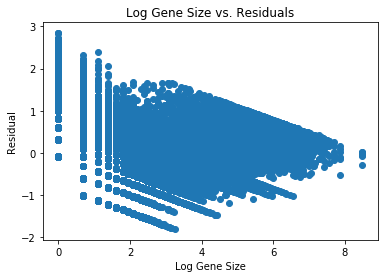

In [52]:
plt.scatter(np.array(geneLog_taxonLog_scoresLog['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

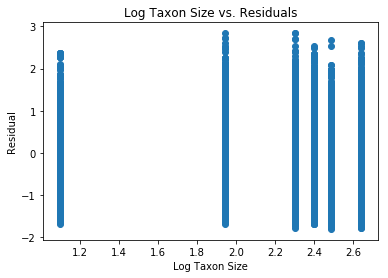

In [53]:
plt.scatter(np.array(geneLog_taxonLog_scoresLog['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## OLS on box cox gene profile size, box cox taxon profile size, scores.

In [54]:
ols_results_geneBoxCox_taxonBoxCox_Scores = ols_multiple_regression(geneBoxCox_taxonBoxCox_scores, 
                                                                   False, False, False, True, True, False)
print(ols_results_geneBoxCox_taxonBoxCox_Scores.params)
print('R squared '+str(ols_results_geneBoxCox_taxonBoxCox_Scores.rsquared))
print('Adjusted R squared '+str(ols_results_geneBoxCox_taxonBoxCox_Scores.rsquared_adj))
print(ols_results_geneBoxCox_taxonBoxCox_Scores.summary())

Intercept      0.005653
taxonBoxCox   -0.000117
geneBoxCox     0.009759
dtype: float64
R squared 0.4977440116396442
Adjusted R squared 0.4977319638089869
                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                 4.131e+04
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:51   Log-Likelihood:             2.1920e+05
No. Observations:               83380   AIC:                        -4.384e+05
Df Residuals:                   83377   BIC:                        -4.384e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t| 

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

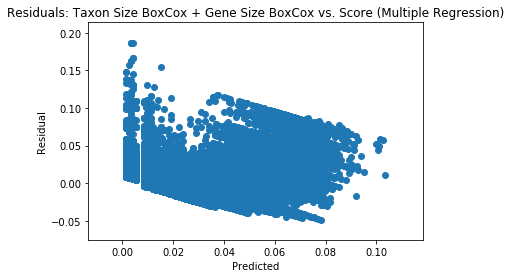

In [55]:
residuals = compute_residuals(ols_results_geneBoxCox_taxonBoxCox_Scores, geneBoxCox_taxonBoxCox_scores)
predicted = ols_results_geneBoxCox_taxonBoxCox_Scores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

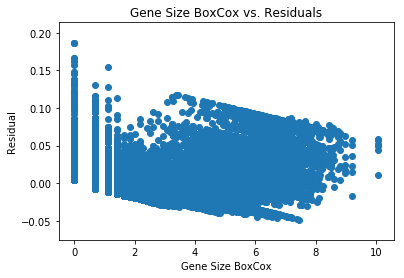

In [56]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scores['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

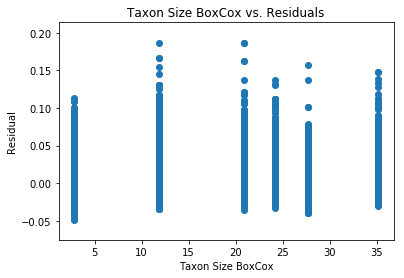

In [57]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scores['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## OLS on box cox gene profile size, box cox taxon profile size, box cox scores.

In [58]:
ols_results_geneBoxCox_taxonBoxCox_ScoresBoxCox = ols_multiple_regression(geneBoxCox_taxonBoxCox_scoresBoxCox, 
                                                                   False, False, False, True, True, True)
print(ols_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.params)
print('R squared '+str(ols_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.rsquared))
print('Adjusted R squared '+str(ols_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.rsquared_adj))
print(ols_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.summary())

Intercept     -2.986302
taxonBoxCox   -0.000595
geneBoxCox     0.139762
dtype: float64
R squared 0.5351332399602292
Adjusted R squared 0.5351220890010908
                            OLS Regression Results                            
Dep. Variable:           scoresBoxCox   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 4.799e+04
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:47:54   Log-Likelihood:                 3688.9
No. Observations:               83380   AIC:                            -7372.
Df Residuals:                   83377   BIC:                            -7344.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t| 

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

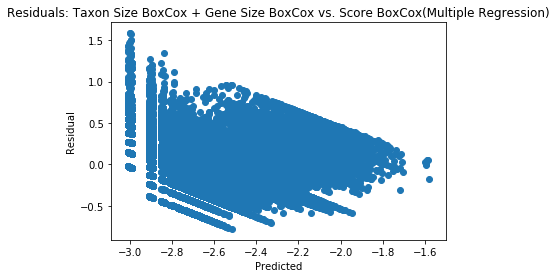

In [59]:
residuals = compute_residuals(ols_results_geneBoxCox_taxonBoxCox_ScoresBoxCox, geneBoxCox_taxonBoxCox_scoresBoxCox)
predicted = ols_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Score BoxCox(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

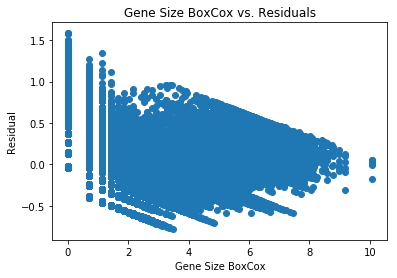

In [60]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scoresBoxCox['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

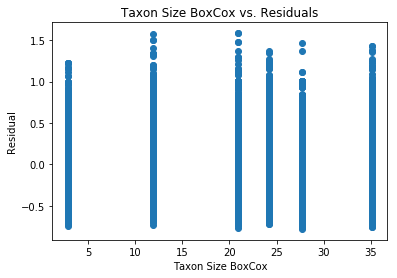

In [61]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scoresBoxCox['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## WLS Multi Regression

For the weights of each data point we will use the number of times the pair (gene profile size, taxon profile size) appears in the data set. That should be relevant thowards how important that data point is for the overall data and modeling.

## Computing pair count (taxon, gene)-score

In [62]:
gene_taxon_pair_count = gene_taxon_scores.groupby(['taxon','gene']).size().reset_index(name='count')
revised_counts = gene_taxon_scores.copy(deep=True)
revised_counts['count'] = 0
for i in revised_counts.index:
    count = gene_taxon_pair_count[gene_taxon_pair_count.taxon == revised_counts.at[i,'taxon']]
    count = count[count.gene == revised_counts.at[i,'gene']]    
    revised_counts.at[i, 'count'] = count['count']
print(revised_counts.head())
# print(gene_taxon_pair_count.head())

   gene  taxon  scores  count
0    85     11   0.050     38
1   123     11   0.060     15
2    64     11   0.050     53
3    20     11   0.020    160
4   124     11   0.055     22


In [63]:
def wls_multiple_regression(input_data):
    
    if input_data is None:
        return               
        
    y = input_data.iloc[:,2]    
    X = input_data[input_data.columns[0:2]]
    weights = revised_counts['count']    
    X = sm.add_constant(X)
    results = smf.WLS(y, X, weights).fit()
    return results    

## WLS on gene profile size, taxon profile size, scores.

In [64]:
wls_results_gene_taxon_Scores = wls_multiple_regression(gene_taxon_scores)
print(wls_results_gene_taxon_Scores.params)
print('R squared '+str(wls_results_gene_taxon_Scores.rsquared))
print('Adjusted R squared '+str(wls_results_gene_taxon_Scores.rsquared_adj))
print(wls_results_gene_taxon_Scores.summary())

const    0.020062
gene     0.000271
taxon    0.000013
dtype: float64
R squared 0.18380811085094317
Adjusted R squared 0.1837885325046571
                            WLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.184
Model:                            WLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     9388.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:49:02   Log-Likelihood:             2.0258e+05
No. Observations:               83380   AIC:                        -4.052e+05
Df Residuals:                   83377   BIC:                        -4.051e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

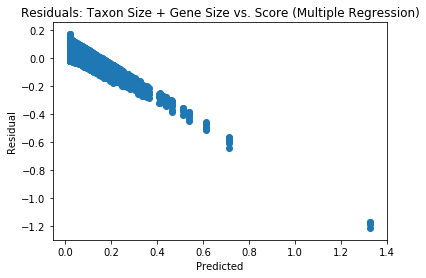

In [65]:
residuals = compute_residuals(wls_results_gene_taxon_Scores, gene_taxon_scores)
predicted = wls_results_gene_taxon_Scores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size + Gene Size vs. Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

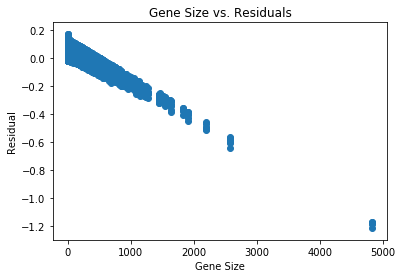

In [66]:
plt.scatter(np.array(gene_taxon_scores['gene']), np.array(residuals))
plt.title('Gene Size vs. Residuals')
plt.xlabel('Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

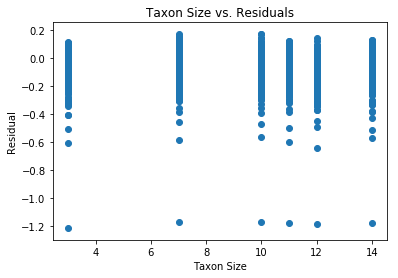

In [67]:
plt.scatter(np.array(gene_taxon_scores['taxon']), np.array(residuals))
plt.title('Taxon Size vs. Residuals')
plt.xlabel('Taxon Size')
plt.ylabel('Residual')

## WLS on log gene profile size, log taxon profile size, scores.

In [68]:
wls_results_geneLog_taxonLog_Scores = wls_multiple_regression(geneLog_taxonLog_scores)
print(wls_results_geneLog_taxonLog_Scores.params)
print('R squared '+str(wls_results_geneLog_taxonLog_Scores.rsquared))
print('Adjusted R squared '+str(wls_results_geneLog_taxonLog_Scores.rsquared_adj))
print(wls_results_geneLog_taxonLog_Scores.summary())

const       0.014008
geneLog     0.004830
taxonLog    0.000597
dtype: float64
R squared 0.13048116050310332
Adjusted R squared 0.13046030298029743
                            WLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.130
Model:                            WLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     6256.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:49:05   Log-Likelihood:             1.9994e+05
No. Observations:               83380   AIC:                        -3.999e+05
Df Residuals:                   83377   BIC:                        -3.999e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

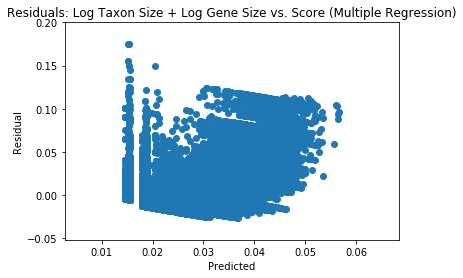

In [69]:
residuals = compute_residuals(wls_results_geneLog_taxonLog_Scores, geneLog_taxonLog_scores)
predicted = wls_results_geneLog_taxonLog_Scores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

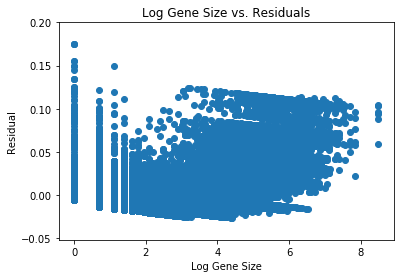

In [70]:
plt.scatter(np.array(geneLog_taxonLog_scores['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

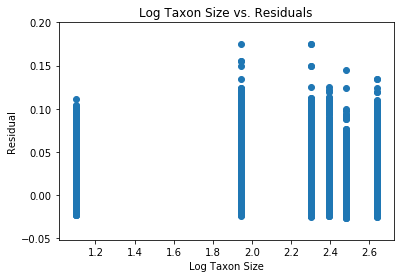

In [71]:
plt.scatter(np.array(geneLog_taxonLog_scores['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## WLS on log gene profile size, log taxon profile size, log scores.

In [72]:
wls_results_geneLog_taxonLog_ScoresLog = wls_multiple_regression(geneLog_taxonLog_scoresLog)
print(wls_results_geneLog_taxonLog_ScoresLog.params)
print('R squared '+str(wls_results_geneLog_taxonLog_ScoresLog.rsquared))
print('Adjusted R squared '+str(wls_results_geneLog_taxonLog_ScoresLog.rsquared_adj))
print(wls_results_geneLog_taxonLog_ScoresLog.summary())

const      -4.312186
geneLog     0.203323
taxonLog    0.009871
dtype: float64
R squared 0.14980985656385037
Adjusted R squared 0.1497894626867996
                            WLS Regression Results                            
Dep. Variable:              scoresLog   R-squared:                       0.150
Model:                            WLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     7346.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:49:08   Log-Likelihood:            -1.0511e+05
No. Observations:               83380   AIC:                         2.102e+05
Df Residuals:                   83377   BIC:                         2.102e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.0

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

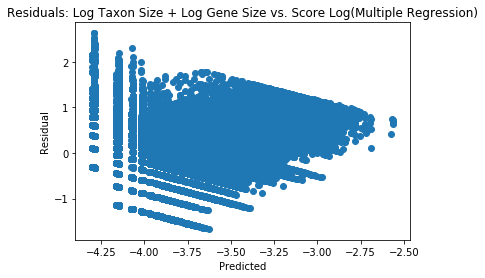

In [73]:
residuals = compute_residuals(wls_results_geneLog_taxonLog_ScoresLog, geneLog_taxonLog_scoresLog)
predicted = wls_results_geneLog_taxonLog_ScoresLog.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Log Taxon Size + Log Gene Size vs. Score Log(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

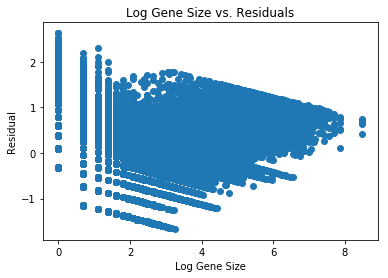

In [74]:
plt.scatter(np.array(geneLog_taxonLog_scoresLog['geneLog']), np.array(residuals))
plt.title('Log Gene Size vs. Residuals')
plt.xlabel('Log Gene Size')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

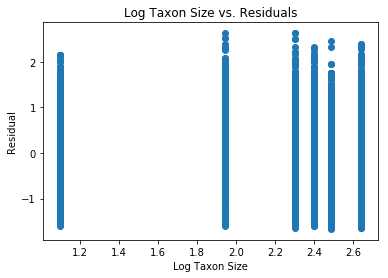

In [75]:
plt.scatter(np.array(geneLog_taxonLog_scoresLog['taxonLog']), np.array(residuals))
plt.title('Log Taxon Size vs. Residuals')
plt.xlabel('Log Taxon Size')
plt.ylabel('Residual')

## WLS on box cox gene profile size, box cox taxon profile size, scores.

In [76]:
wls_results_geneBoxCox_taxonBoxCox_Scores = wls_multiple_regression(geneBoxCox_taxonBoxCox_scores)
print(wls_results_geneBoxCox_taxonBoxCox_Scores.params)
print('R squared '+str(wls_results_geneBoxCox_taxonBoxCox_Scores.rsquared))
print('Adjusted R squared '+str(wls_results_geneBoxCox_taxonBoxCox_Scores.rsquared_adj))
print(wls_results_geneBoxCox_taxonBoxCox_Scores.summary())

const          0.015422
geneBoxCox     0.004549
taxonBoxCox   -0.000003
dtype: float64
R squared 0.13629853718656104
Adjusted R squared 0.13627781920767457
                            WLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.136
Model:                            WLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     6579.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:49:11   Log-Likelihood:             2.0022e+05
No. Observations:               83380   AIC:                        -4.004e+05
Df Residuals:                   83377   BIC:                        -4.004e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

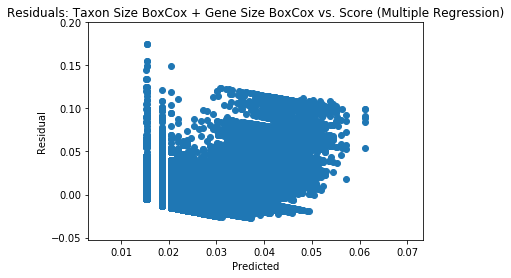

In [77]:
residuals = compute_residuals(wls_results_geneBoxCox_taxonBoxCox_Scores, geneBoxCox_taxonBoxCox_scores)
predicted = wls_results_geneBoxCox_taxonBoxCox_Scores.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Score (Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

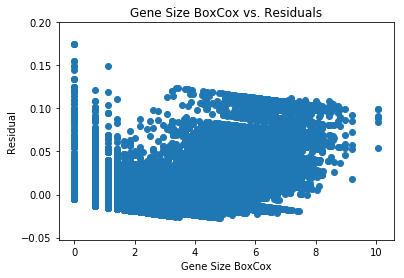

In [78]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scores['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

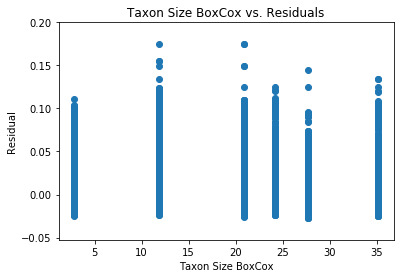

In [79]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scores['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')

## WLS on box cox gene profile size, box cox taxon profile size, box cox scores.

In [80]:
wls_results_geneBoxCox_taxonBoxCox_ScoresBoxCox = wls_multiple_regression(geneBoxCox_taxonBoxCox_scoresBoxCox)
print(wls_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.params)
print('R squared '+str(wls_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.rsquared))
print('Adjusted R squared '+str(wls_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.rsquared_adj))
print(wls_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.summary())

const         -2.884742
geneBoxCox     0.089689
taxonBoxCox   -0.000239
dtype: float64
R squared 0.1583713396932237
Adjusted R squared 0.1583511511841551
                            WLS Regression Results                            
Dep. Variable:           scoresBoxCox   R-squared:                       0.158
Model:                            WLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     7845.
Date:                Tue, 06 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:49:14   Log-Likelihood:                -41061.
No. Observations:               83380   AIC:                         8.213e+04
Df Residuals:                   83377   BIC:                         8.216e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t| 

## 3 Residual plots:

    *predicted vs residuals
    *gene vs residuals
    *taxon vs residuals

Text(0,0.5,'Residual')

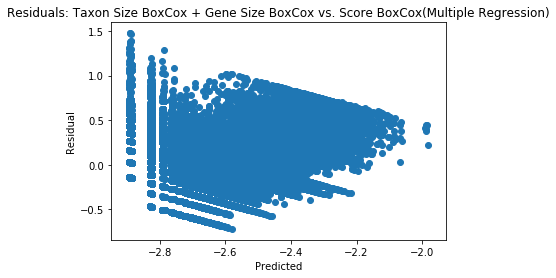

In [81]:
residuals = compute_residuals(wls_results_geneBoxCox_taxonBoxCox_ScoresBoxCox, geneBoxCox_taxonBoxCox_scoresBoxCox)
predicted = wls_results_geneBoxCox_taxonBoxCox_ScoresBoxCox.fittedvalues

plt.scatter(np.array(predicted), np.array(residuals))
plt.title('Residuals: Taxon Size BoxCox + Gene Size BoxCox vs. Score BoxCox(Multiple Regression)')
plt.xlabel('Predicted')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

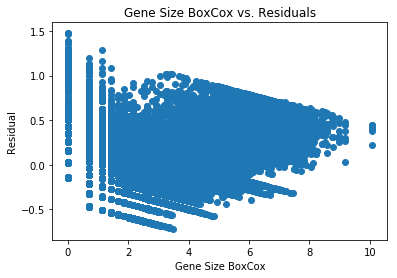

In [82]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scoresBoxCox['geneBoxCox']), np.array(residuals))
plt.title('Gene Size BoxCox vs. Residuals')
plt.xlabel('Gene Size BoxCox')
plt.ylabel('Residual')

Text(0,0.5,'Residual')

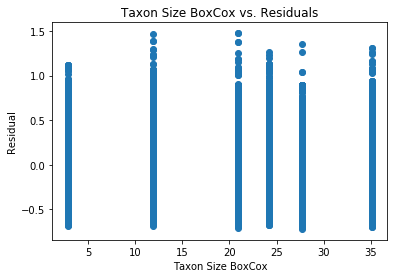

In [83]:
plt.scatter(np.array(geneBoxCox_taxonBoxCox_scoresBoxCox['taxonBoxCox']), np.array(residuals))
plt.title('Taxon Size BoxCox vs. Residuals')
plt.xlabel('Taxon Size BoxCox')
plt.ylabel('Residual')